In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm

from models import JacobianCI

In [3]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    for epoch in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        loss_history.append(loss)
    loss_history = np.array(loss_history)
    return loss_history

In [4]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
#loss_history = train_model(model)

## Linear Euclidean decoder

In [5]:
rs = model.unit_cell.sample(2**10)
rs = torch.tensor(rs,dtype=dtype)
def linear_decoder(model, rs):
    model.train_decoder(rs)
    rs_pred = model.decode(model(rs)).detach()
    error = torch.linalg.norm(rs_pred - rs, dim=1)**2
    return rs_pred, error
model.train_decoder(rs)
rs_pred = model.decode(model(rs)).detach()
error = torch.linalg.norm(rs_pred - rs, dim=1)

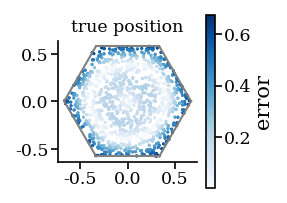

In [6]:
fig,ax = plt.subplots(figsize=(1.5,1.5))
ax.scatter(rs[:,0],rs[:,1],c=error)
ax.axes.set_aspect('equal')
ax.set_title("true position", fontsize='small')
model.unit_cell.plot(fig,ax,color="grey")
# add colorbar
cbar = fig.colorbar(ax.scatter(rs[:,0],rs[:,1],c=error), ax=ax)
cbar.set_label("error")

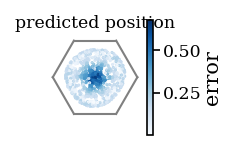

In [7]:
fig, ax = plt.subplots(figsize=(1,1))
im = ax.scatter(rs_pred[:,0],rs_pred[:,1],c=error)
ax.axes.set_aspect('equal')
ax.set_title("predicted position", fontsize='small')
ax.axis('off')
model.unit_cell.plot(fig,ax,color="grey")
# add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("error")
fig.savefig("../results/decoder.svg", bbox_inches='tight')

tensor(0.2335) tensor(0.1604)


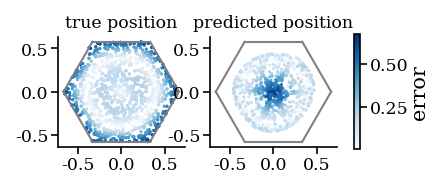

In [8]:
fig,axs = plt.subplots(ncols=2,figsize=(3,1))
axs[0].scatter(rs[:,0],rs[:,1],c=error)
axs[0].axes.set_aspect('equal')
axs[0].set_title("true position", fontsize='small')
model.unit_cell.plot(fig,axs[0],color="grey")
axs[1].scatter(rs_pred[:,0],rs_pred[:,1],c=error)
axs[1].axes.set_aspect('equal')
axs[1].set_title("predicted position", fontsize='small')
model.unit_cell.plot(fig,axs[1],color="grey")
print(torch.mean(error), torch.std(error))
# common colorbar
fig.colorbar(axs[0].scatter(rs[:,0],rs[:,1],c=error), ax=axs, label='error')

## Maximum activity decoder

In [9]:
def max_decoder(model, rs):
    rs = torch.tensor(rs,dtype=dtype)
    activity = model(rs).detach()
    max_cell = torch.argmax(activity,dim=1)
    rs_pred = [model.phases[cell].detach() for cell in max_cell]
    rs_pred = torch.stack(rs_pred)
    error = torch.linalg.norm(rs_pred - rs, dim=1)**2
    return rs_pred, error

rs = model.unit_cell.sample(2**10)
rs = torch.tensor(rs,dtype=dtype)
rs_pred, error = max_decoder(model, rs)

/var/folders/r6/cx14fc_93r7091_cqzygrslr0000gn/T/ipykernel_21952/3408150590.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rs = torch.tensor(rs,dtype=dtype)


tensor(0.1940) tensor(0.3552)


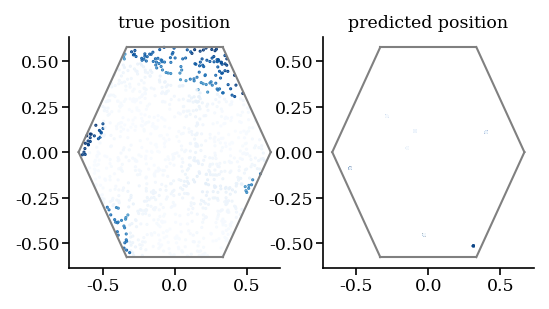

In [10]:
fig,axs = plt.subplots(ncols=2,figsize=(4,2))
axs[0].scatter(rs[:,0],rs[:,1],c=error)
axs[0].set_title("true position", fontsize='small')
model.unit_cell.plot(fig,axs[0],color="grey")
axs[1].scatter(rs_pred[:,0],rs_pred[:,1],c=error)
axs[1].set_title("predicted position", fontsize='small')
model.unit_cell.plot(fig,axs[1],color="grey")
print(torch.mean(error), torch.std(error))

In [18]:
rs = model.unit_cell.sample(2**10)
rs = torch.tensor(rs,dtype=dtype)
linear_error = []
max_error = []
for ncells in tqdm.trange(3, 1000, 4):
    model = JacobianCI(ncells=ncells,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
    linear_error.append(linear_decoder(model, rs)[1])
    max_error.append(max_decoder(model, rs)[1])
linear_error = torch.stack(linear_error)
max_error = torch.stack(max_error)
linear_error.shape, max_error.shape

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/r6/cx14fc_93r7091_cqzygrslr0000gn/T/ipykernel_21952/3408150590.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rs = torch.tensor(rs,dtype=dtype)
100%|██████████| 250/250 [00:06<00:00, 39.63it/s]


(torch.Size([250, 1024]), torch.Size([250, 1024]))

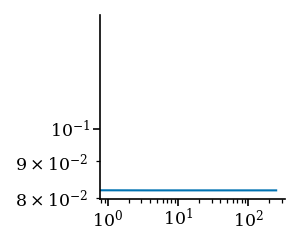

In [19]:
plt.loglog(torch.mean(linear_error, dim=1).T, label='linear');
# add error bars
#plt.fill_between(torch.arange(1, 100), torch.mean(linear_error, dim=1).T - torch.std(linear_error, dim=1).T, torch.mean(linear_error, dim=1).T + torch.std(linear_error, dim=1).T, alpha=0.5)
#plt.plot(torch.mean(max_error, dim=1).T, label='max');
#plt.loglog(torch.mean(max_error, dim=1).T, label='max');
# add error bars
#plt.fill_between(torch.arange(1, 100), torch.mean(max_error, dim=1).T - torch.std(max_error, dim=1).T, torch.mean(max_error, dim=1).T + torch.std(max_error, dim=1).T, alpha=0.5)

## Local Linear Euclidean decoder (integrator)

In [13]:
class RandomWalk2D(object):
    # Simple dataset maker; square box + bounce off walls
    def __init__(self, box_size = 2*np.pi, von_mises_scale = 4*np.pi, rayleigh_scale = 0.15):
        self.box_size = box_size # box_size x box_size enviroment
        self.von_mises_scale = von_mises_scale
        self.rayleigh_scale = rayleigh_scale

    def bounce(self, r, v):
        # bounce off walls if next step lands outside
        outside = np.abs(r + v) >= self.box_size
        v[outside] = -v[outside]
        return v

    def generate_data(self, samples, timesteps, device = "cpu"):
        r = np.zeros((samples, timesteps, 2)) # positions
        s = np.random.rayleigh(self.rayleigh_scale, (samples, timesteps)) # speeds

        # initial conditions
        prev_hd = np.random.uniform(0, 2*np.pi, samples) # previous head direction
        r[:,0] = np.random.uniform(-self.box_size, self.box_size, (samples, 2))

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, self.von_mises_scale, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v)
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v

        v = np.diff(r, axis = 1) # velocities
        return np.squeeze(r), np.squeeze(v)

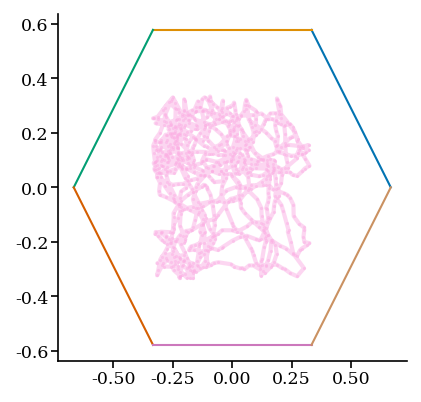

In [14]:
randomwalk = RandomWalk2D(box_size:=1/3, von_mises_scale=5, rayleigh_scale=0.02)
rs,vs = randomwalk.generate_data(1, 1000)
# plot random walk
fig, ax = plt.subplots(figsize=(3,3))
model.unit_cell.plot(fig,ax)
ax.plot(*rs.T,"-o",alpha=0.5,lw=2)

In [15]:
activity = model(torch.tensor(rs,dtype=dtype))
# create decoder input (rs, activity)
X = torch.cat([torch.tensor(rs[:-1],dtype=dtype),activity[1:]],dim=1)
# add bias
X = torch.cat([X,torch.ones(X.shape[0],1,dtype=dtype)],dim=1)
# decoder ground truth
Y = torch.tensor(rs[1:],dtype=dtype)
print(X.shape, Y.shape)
# solve for decoder
decoder = torch.linalg.lstsq(X, Y).solution
# predict
rs_pred = X @ decoder
error = torch.linalg.norm(rs_pred - Y, dim=1)
error.mean(), torch.linalg.norm(torch.tensor(rs[:-1], dtype=dtype) - Y, dim=1).mean()

torch.Size([999, 102]) torch.Size([999, 2])


(tensor(0.0221, grad_fn=<MeanBackward0>), tensor(0.0253))

tensor(0.0221, grad_fn=<MeanBackward0>) tensor(0.0121, grad_fn=<StdBackward0>)


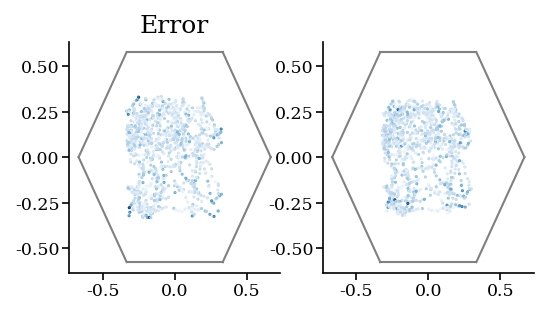

In [16]:
error = torch.linalg.norm(rs_pred - Y, dim=1)
fig,axs = plt.subplots(ncols=2,figsize=(4,2))
axs[0].scatter(*Y.detach().numpy().T,c=error.detach().numpy())
axs[0].set_title("Error")
model.unit_cell.plot(fig,axs[0],color="grey")
axs[1].scatter(*rs_pred.detach().numpy().T,c=error.detach().numpy())
model.unit_cell.plot(fig,axs[1],color="grey")
print(torch.mean(error), torch.std(error))

In [17]:
rs,vs = randomwalk.generate_data(100, 50)
activity = model(torch.tensor(rs.reshape(-1,2),dtype=dtype)).reshape(100,50,7)
X = torch.cat([torch.tensor(rs[:,:-1],dtype=dtype),activity[:,1:]],dim=2)
X = torch.cat([X,torch.ones_like(X)[...,:1]],dim=2)
Y = torch.tensor(rs[:,1:],dtype=dtype)
rs_pred = X @ decoder
error = torch.linalg.norm(rs_pred - Y, dim=-1)

RuntimeError: shape '[100, 50, 7]' is invalid for input of size 495000

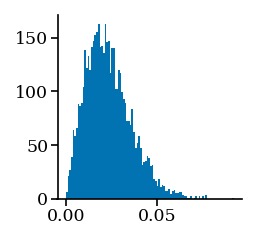

In [14]:
plt.hist(error.flatten().detach().numpy(),bins=100);